# 6. 학습 관련 기술들

이번 장은 신경망 학습의 핵심 개념들

가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정방법, 오버피팅 대응책인 가중치 감소와 드롭아웃 등

마지막은 배치 정규화도 간략하게 알아보자 

이러한 기법들을 사용하면 딥러닝의 학습 효율과 정확도를 높일 수 있음

## 6.1 매개변수 갱신
매개변수의 최적값을 찾는 문제 -> 최적화

### 6.1.2 확률적 경사 하강법(SGD)
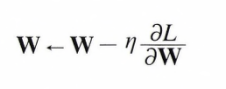

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

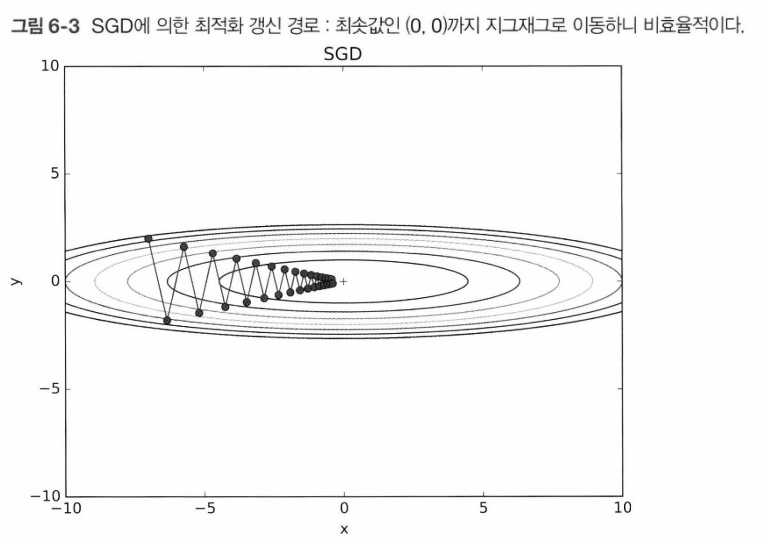

### 6.1.4 모멘텀
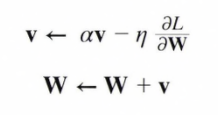
v는 속도를 의미
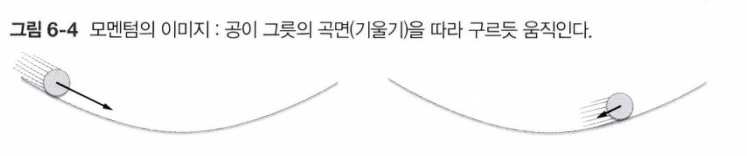

av 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 합니다
(a는 0.9 등의 값으로 설정합니다). 물리에서의 지면 마찰이나 공기 저항에 해당

In [2]:
import numpy as np

class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

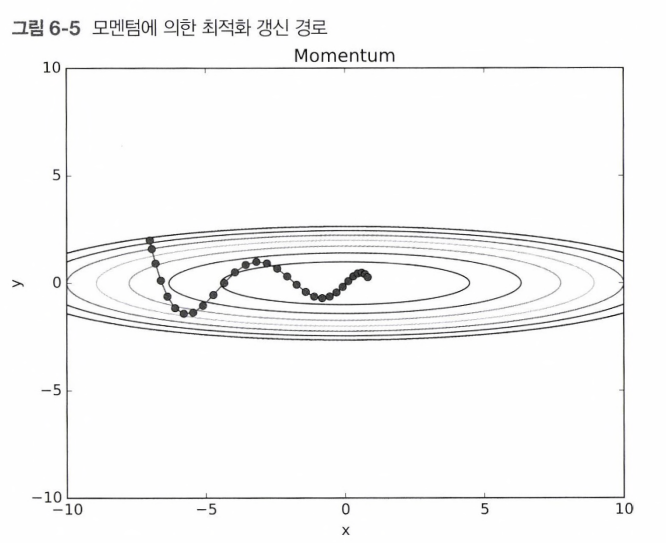

x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문

거꾸로 y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않음. 

전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어듬

### 6.1.5 AdaGrad
신경망 학습에서는 lr 값이 중요.(작으면 학습시간 too long, 크면 발산할 수 있음)

이 lr(학습률)을 정하는 효과적 기술 -> 학습률 감소(처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기)

학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 ‘전체’의 학습률 값을 일괄적으로 낮추는 것. 이를 더욱 발전시킨 것이 AdaGrad

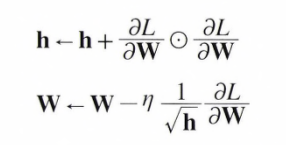

AdaGrad는 ‘각각의' 매개변수에 ‘맞춤형’값을 만들어줌


In [3]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

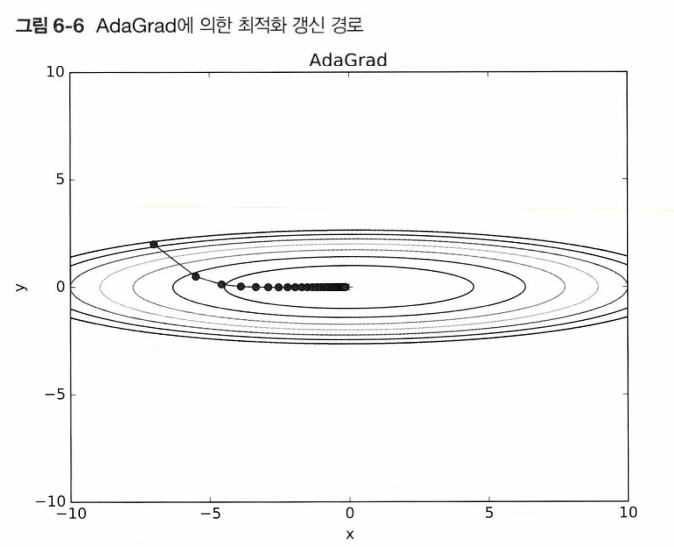

### 6.1.6 Adam
모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임, AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정 -> 이 두가지를 융합하는 생각 -> Adam

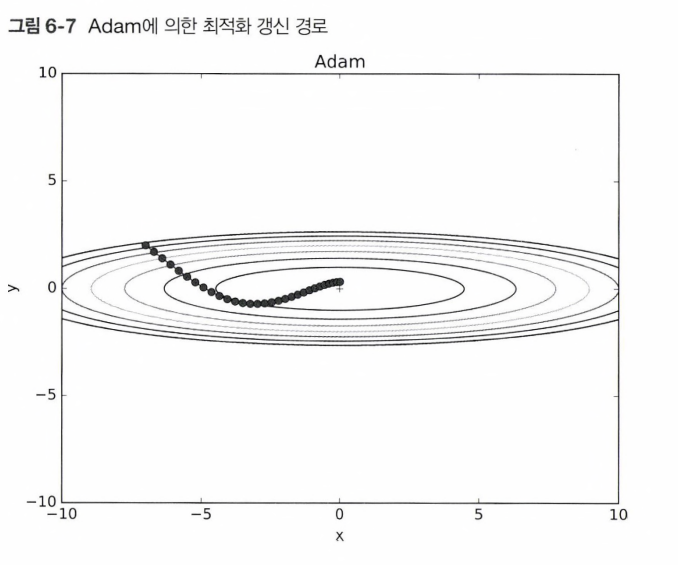

## 6.2 가중치의 초깃값
신경망 학습에서 특히 중요한 것이 가중치의 초깃값.

### 6.2.1 초깃값을 0으로 하면?
학습이 올바르게 이뤄지지 않음. 

그 이유는 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문임.

    ex) 2층 신경망에서 첫 번째와 두 번째 층의 가중치가 0이라고 가정. 그럼 순전파 때는 입력층의 가중치가 0이므로 두번째 층의 뉴런에 모두 같은 값이 전달. 
    두번째 층의 모든 뉴런에 같은 값이 입력된다는 것은 역전파 때 두번째 층의 가중치가 모두 똑같이 갱신된다는 말이 된다.
    그래서 가중치들은 같은 초깃값에서 싲가하고 갱신을 거쳐도 여전히 같은 값을 유지하는 것

## 6.2.2 은닉층의 활성화값 분포
은닉층의 활성화값(활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있음

아래는 가중치의 초깃값에 따라 은닉층의 활성화 값들이 어떻게 변화하는지 간단하게 실험

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 100개의 데이터
node_num = 100 # 각 은닉층의 노드 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

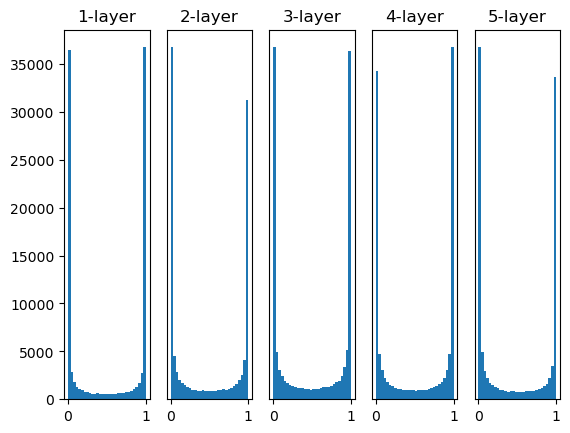

In [39]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()

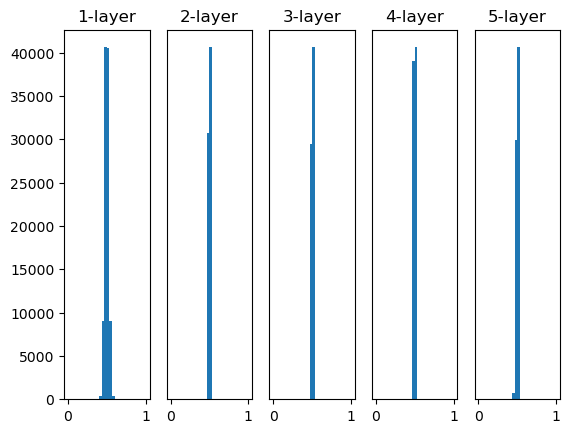

In [40]:
x = np.random.randn(1000, 100) # 100개의 데이터
node_num = 100 # 각 은닉층의 노드 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01
    
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()

위 처럼 가중치의 표준편차를 0.01로 바꾸면 0.5 부근에 집중된 것을 볼 수 있음. 

기울시 소실 문제는 일어나지 않지만, 활성화 값들이 치우쳤다는 것은 큰 문제가 있는 것(다수의 뉴련이 거의 같은 값을 출력하고 있으니 뉴련을 여러개 둔 의미가 없어진다는 뜻)

Xavier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼짐

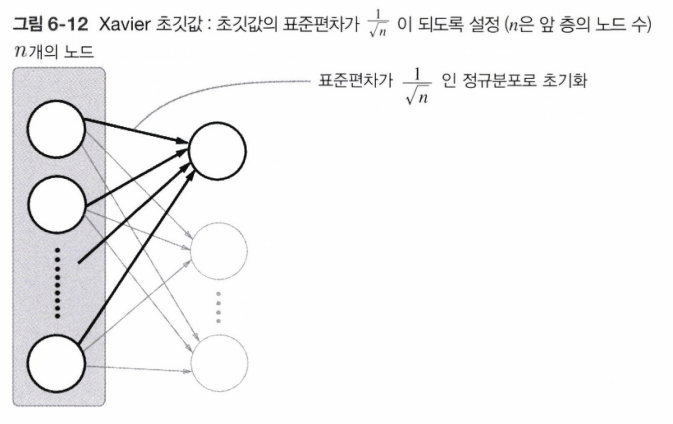

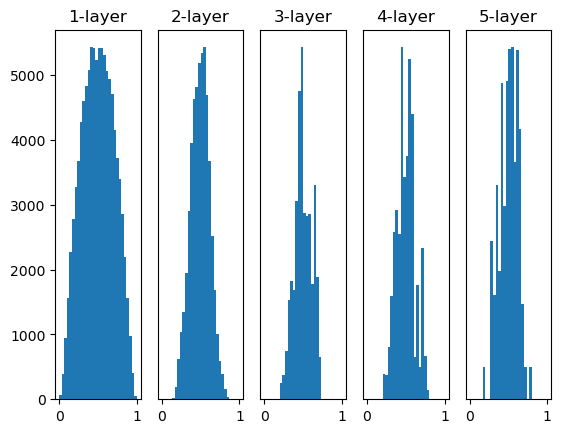

In [41]:
x = np.random.randn(1000, 100) # 100개의 데이터
node_num = 100 # 각 은닉층의 노드 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    node_num = 100
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값
Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과

sigmoid 함수와 tanh함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있음. 그래서 Xavier 초깃값이 적당함

반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장 -> He 초깃값

He 초깃값은 앞 계층의 노드가 개일n 때, 표준편차가 루트2/n 인 정규분포를 사용(Xavier는 초깃값이 루트1/n)

ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 (직감적으로) 해석할 수 있음

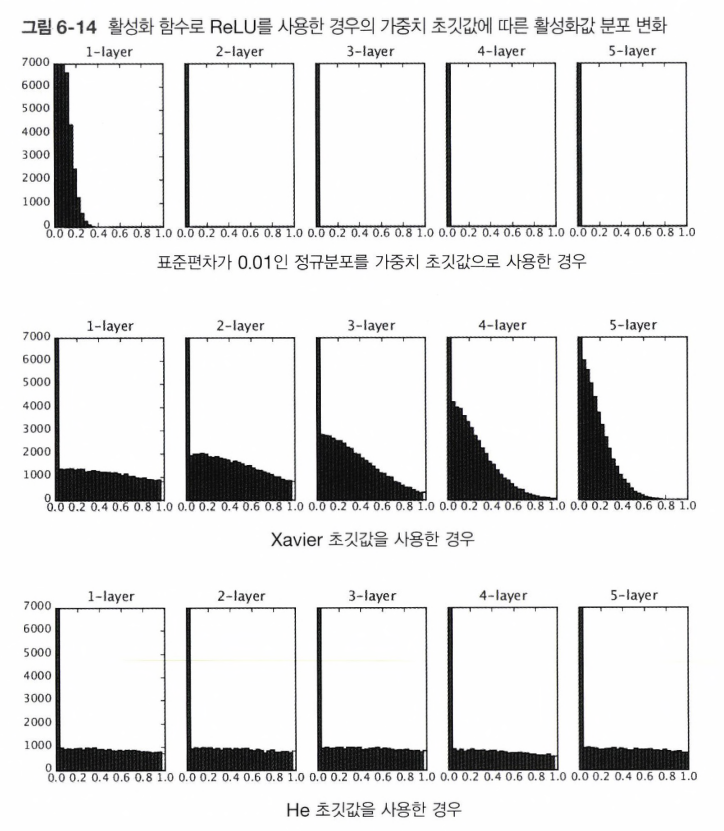

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교
실제 데이터를 가지고 가중치 초깃값을 주는 방법이 신경망 학습에 얼마나 영향을 주는지 보겠음.

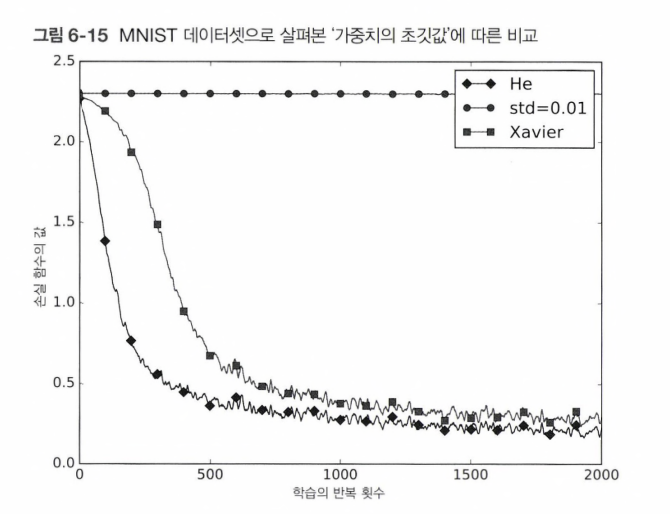

std = 0.01 일 때는 학습이 전혀 이뤄지지 않음.(활성화값의 분포에서 본 것처럼 순전파 때 너무 작은 값(0 근처로 밀집한 데이터)이 흐르기 때문)

## 6.3 배치 정규화
앞 절에서 가중치의 초깃값을 적절히 설정하면 각 층의 활성화 값 분포가 퍼지면서 원활하게 수행됨을 배웠음.

그렇다면 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하면 어떨까? -> 배치 정규화가 이런 아이디어에서 출발한 방법

### 6.3.1 배치 정규화 알고리즘

배치 정규화가 주목받는 이유
- 학습을 빨리 진행할 수 있음 (학습 속도 개선)
- 초깃값에 크게 의존하지 않는다. (골치 아픈 초깃값 선택 장애 ㅂ2ㅂ2)
- 오버피팅을 억제한다. (드롭아웃 등의 필요성 감소)

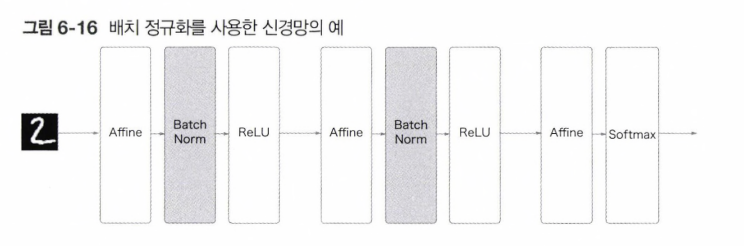

배치 정규화는 그 이름과 같이 학습 시 미니배치를 단위로 정규화. 
구체적으로는 데이터 분포가 평균이 0, 분산이 1 이 되도록 정규화함

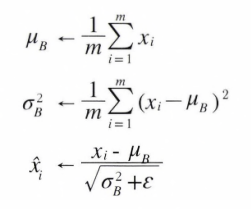

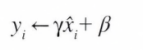 μ: 평균, σ^2: 분산

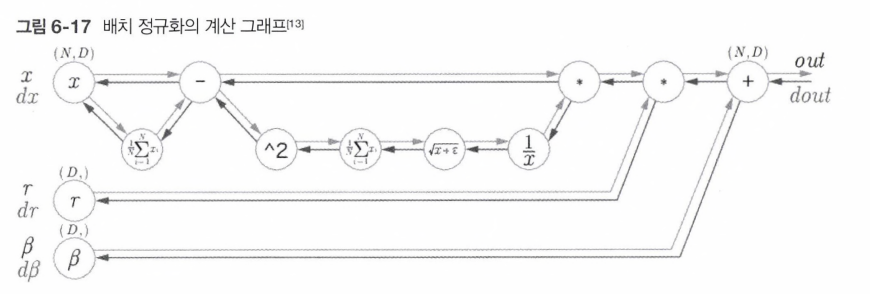

## 6.4 바른 학습을 위해

### 6.4.1 오버피팅
오버피팅은 주로 다음의 두 경우에 발생
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

MNIST 6만개의 훈련데이터 중 300개만 사용하고 7층 네트워크를 사용해 네트워크의 복잡성을 높여 일부러 오버피팅을 일으켜 보겠음.

각 층의 뉴련은 100개, 활성화 함수는 ReLU

In [42]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)
# 오버피팅을 재현하기위해 줄인 데이터
x_train = x_train[:300]
t_train = t_train[:300]

In [45]:
from common.multi_layer_net import MultiLayerNet

network = MultiLayerNet(input_size = 784, hidden_size_list= [100, 100, 100, 100, 100, 100], output_size = 10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

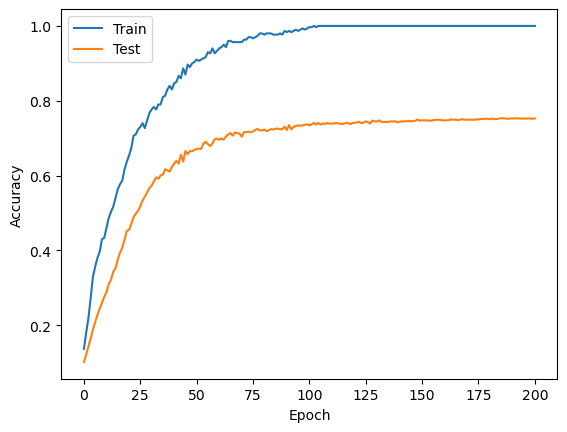

In [46]:
plt.plot(train_acc_list, label = 'Train')
plt.plot(test_acc_list, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

100에폭을 넘어가는 시점부터 거의 100% -> 오버피팅

### 6.4.2 가중치 감소

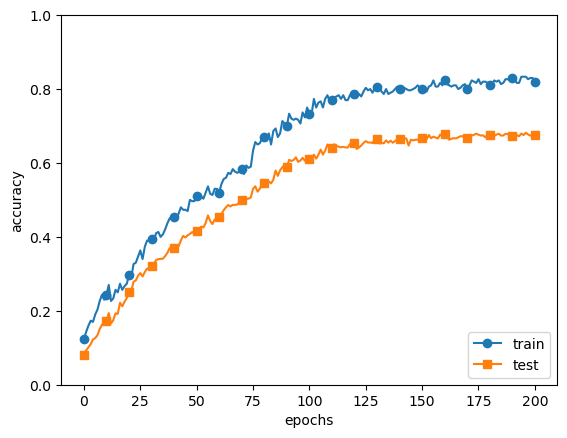

In [48]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 6.4.3 드롭아웃
신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워짐. -> 드롭아웃 기법을 이용

드롭아웃: 뉴런을 임의로 삭제하면서 학습하는 방법

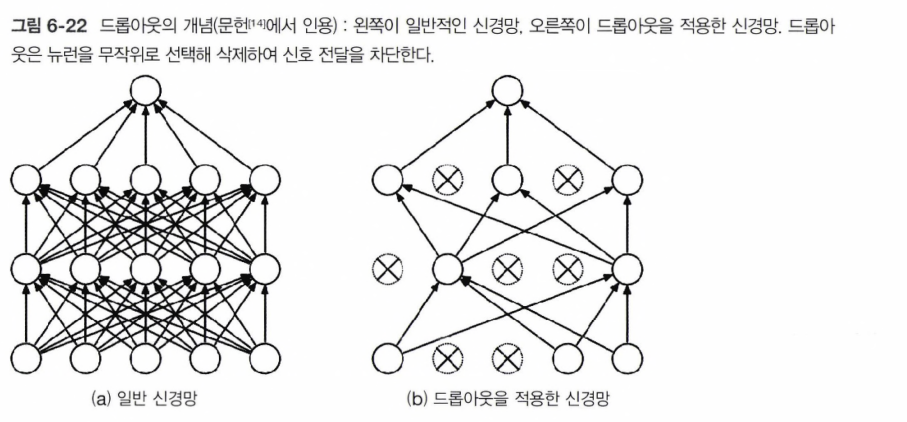

In [49]:
# 간단하게만 구현한 코드임
class Drout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg = True):
        if train_flg: # 훈련 중일 때는 드롭아웃을 활성화
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            return x * self.mask # x와 self.mask를 곱하여, 마스크된 뉴런은 비활성화되고, 나머지 뉴런은 값 그대로 유지
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.3381519350319384
=== epoch:1, train acc:0.09666666666666666, test acc:0.1026 ===
train loss:2.313783531722744
train loss:2.34648395891725
train loss:2.3455306299300336
=== epoch:2, train acc:0.09666666666666666, test acc:0.1025 ===
train loss:2.334998786191909
train loss:2.35470364518584
train loss:2.324255416969485
=== epoch:3, train acc:0.09666666666666666, test acc:0.1023 ===
train loss:2.3247116973194113
train loss:2.339620044459427
train loss:2.3265579124891276
=== epoch:4, train acc:0.09, test acc:0.1004 ===
train loss:2.3213768897519973
train loss:2.322721777524488
train loss:2.317654271368727
=== epoch:5, train acc:0.09, test acc:0.0998 ===
train loss:2.3332560305098844
train loss:2.3204409868788543
train loss:2.3074604768954576
=== epoch:6, train acc:0.09, test acc:0.0995 ===
train loss:2.324970132298586
train loss:2.3302779612436226
train loss:2.3200462096062116
=== epoch:7, train acc:0.09, test acc:0.0996 ===
train loss:2.3140897368818774
train loss:2.3388458032

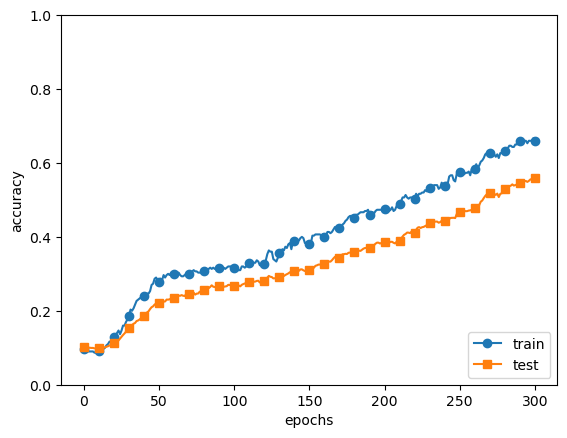

In [50]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.5 적절한 하이퍼파라미터 값 찾기
신경망에는 하이퍼파라미터가 다수 등장. 여기서 말하는 하이퍼파라미터는, 예를 들어 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등을 의미

하이퍼파라미터의 값은 매우 중요하지만 그 값을 결정하기까지는 일반적으로 많은 시행착오를 겪음.


이번 절에서는 하이퍼파라미터의 값을 최대한 효율적으로 탐색하는 방법을 설명

### 6.5.1 검증 데이터
하이퍼파라미터 전용 확인 데이터 -> 검증 데이터

(훈련 데이터는 매개변수(가중치와 편향)의 학습에 이용하고, 검증 데이터는 하이퍼파라미터의 성능을 평가하는데 이용)

In [51]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()
# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 6.5.2 하이퍼파라미터 최적화
하이퍼파라미터를 최적화할 때의 핵심은 하이퍼파라미터의 ‘최적 값’이 존재하는 범위를 조금씩 줄여간다는 것

범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸（샘플링） 후, 그 값으로 정확도를 평가. 

정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 ‘최적 값’의 범위를 좁혀가는 것